In [1]:
using Lehmann

┌ Info: Precompiling Lehmann [95bf888a-8996-4655-9f35-1c0506bdfefe]
└ @ Base loading.jl:1342


In [2]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


In [3]:
diff(a, b) = maximum(abs.(a - b)) # return the maximum deviation between a and b

conformal_tau(τ, β) = -π^(1 / 4) / sqrt(2β) * 1 / sqrt(sin(π * τ / β))

function syk_sigma_dlr(d, G_x, J = 1.0)

    tau_k = d.τ # DLR imaginary time nodes
    tau_k_rev = d.β .- tau_k # Reversed imaginary time nodes

    G_x_rev = tau2tau(d, G_x, tau_k_rev) # G at beta - tau_k

    Sigma_x = J .^ 2 .* G_x .^ 2 .* G_x_rev # SYK self-energy in imaginary time

    # println("sigma diff: ", diff(Sigma_k, dlr2tau(d, Sigma_x)))
    # for i in 1:length(Sigma_x)
    #     println("$(d.τ[i])    $(real(Sigma_x[i]))     $(imag(Sigma_x[i]))")
    # end
    # exit(0)
    # return real.(Sigma_k)
    return Sigma_x
end

syk_sigma_dlr (generic function with 2 methods)

In [4]:
function solve_syk_with_fixpoint_iter(d, mu, tol = d.rtol; mix = 0.3, maxiter = 50, G_x = zeros(ComplexF64, length(d)))

    for iter in 1:maxiter

        # println("G diff: ", diff(G_q, dlr2matfreq(d, G_x)))
        Sigma_x = syk_sigma_dlr(d, G_x)

        # for i in 1:d.size
        #     println("$(d.τ[i])    $(real(Sigma_x_new[i]))     $(imag(Sigma_x_new[i]))")
        # end
        # println(typeof(Sigma_x_new))

        G_q_new = -1 ./ (d.ωn * 1im .- mu .- tau2matfreq(d, Sigma_x)) # Solve Dyson

        G_x_new = matfreq2tau(d, G_q_new)

        println("imag", maximum(abs.(imag.(G_x_new))))

        println(diff(G_x_new, G_x))
        if maximum(abs.(G_x_new .- G_x)) < tol && iter > 5
            break
        end

        G_x = mix * G_x_new + (1 - mix) * G_x # Linear mixing
    end
    return G_x
end

solve_syk_with_fixpoint_iter (generic function with 2 methods)

In [58]:
d = DLRGrid(Euv = 5.0, β = 1000.0, isFermi = true, rtol = 1e-14, symmetry=:ph)

rank = 50 ferminoic DLR with ph symmetry: Euv = 5.0, β = 1000.0, rtol = 1.0e-14
# index                          freq                           tau                            ωn                         n
    1                                 0            9.1916700263057873e-06             0.0031415926535897933                 0
    2             0.0031757284385002739              0.028666105270695928             0.0094247779607693795                 1
    3             0.0051449393747770595              0.079538735321113954              0.015707963267948967                 2
    4             0.0074900030542426905               0.16460188967888603              0.021991148575128551                 3
    5              0.011504145160918433               0.26228574302914248              0.028274333882308138                 4
    6              0.016066637768765206               0.44707223847536282              0.034557519189487719                 5
    7              0.020984026801396459 

In [59]:
function green(d, sigma=zeros(d.size), mu=0.0)
    return -1 ./ (d.ωn * 1im .-mu+sigma)+1 ./ (-d.ωn * 1im .-mu+sigma)
end

green (generic function with 3 methods)

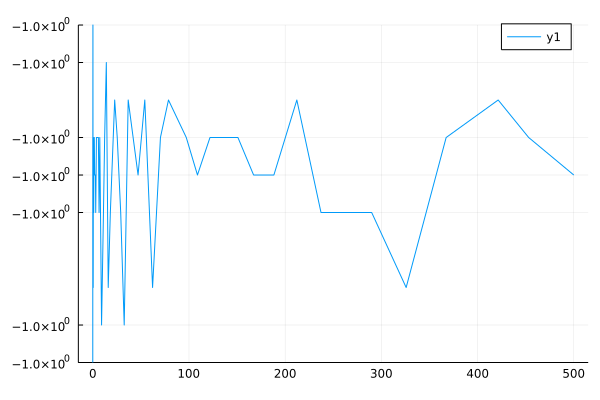

In [60]:
mu=0.0
G_q_new = green(d)
G_x_new = matfreq2tau(d, G_q_new)
plot(d.τ, real.(G_x_new))

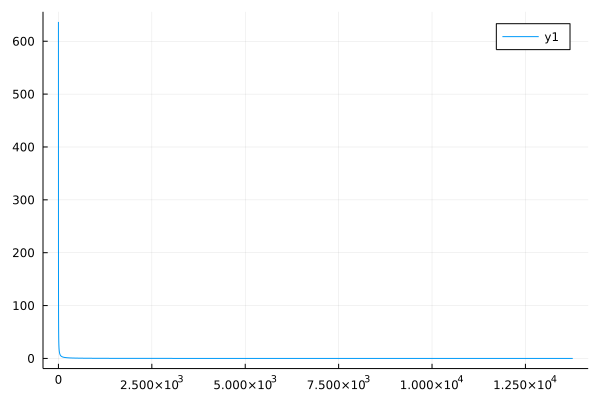

In [65]:

G_q_new = green(d)
G_x_new = matfreq2tau(d, G_q_new)
Sigma_x = syk_sigma_dlr(d, G_x_new)
Sigma_n = tau2matfreq(d, Sigma_x)
plot(d.n, imag.(Sigma_n))
#plot(d.τ, real.(Sigma_x))

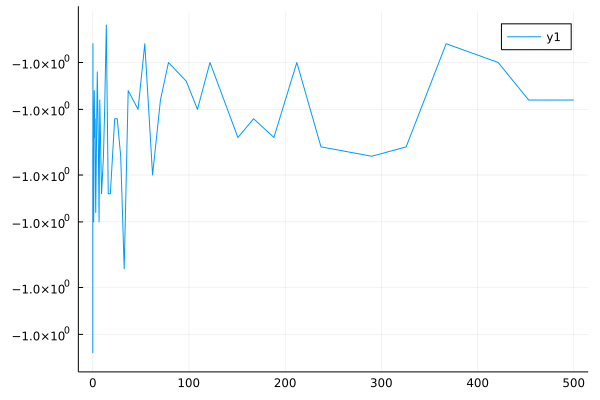

In [66]:
Sigma_t = matfreq2tau(d, Sigma_n)
plot(d.τ, real.(Sigma_t))

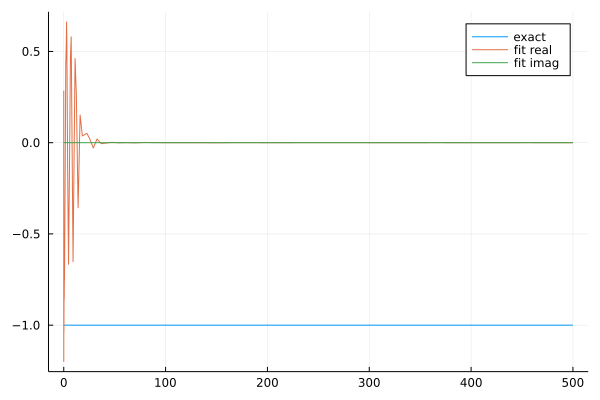

In [67]:
G_q_exact = green(d)
G_q_new = green(d, tau2matfreq(d, Sigma_x))
p = plot(d.τ, real.(matfreq2tau(d, G_q_exact)), label="exact")
plot!(d.τ, real.(matfreq2tau(d, G_q_new)), label="fit real")
plot!(d.τ, imag.(matfreq2tau(d, G_q_new)), label="fit imag")